# Calculating credible intervals
When we combine datasets, by default, we assume that each one is from the same population and that there is no sampling variance. If these assumptions are violated it would lead to overly tight confidence intervals. In reality these assumptions are rarely met and so by default `HLAfreq` does not supply credible intervals.

However, if we model this variance we can obtain accurate credible intervals for the combined allele frequencies. We can do this using `AFhdi()` from the `HLAfreq.HLAfreq_pymc` module which we import as `HLAhdi` below.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import HLAfreq
from HLAfreq import HLAfreq_pymc as HLAhdi

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Download dataset
country = "Mongolia"
locus = "DQB1"

base_url = HLAfreq.makeURL(country, locus=locus)
aftab = HLAfreq.getAFdata(base_url)
aftab = HLAfreq.only_complete(aftab)
HLAfreq.check_resolution(aftab)
aftab = HLAfreq.decrease_resolution(aftab, 2)
caf = HLAfreq.combineAF(aftab)

1 pages of results
Download complete
2    64
3     3
Name: allele, dtype: int64
Multiple resolutions in AFtab. Fix with decrease_resolution()


In [3]:
# Calculate high density intervals
hdi = HLAhdi.AFhdi(aftab, credible_interval=0.95)
# Add to the combined allele frequency dataset
caf = pd.merge(caf, hdi, how="left", on="allele")
caf[['allele', 'allele_freq', 'lo','hi','post_mean']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,allele,allele_freq,lo,hi,post_mean
0,DQB1*02:01,0.102965,0.070885,0.141614,0.107
1,DQB1*02:02,0.062476,0.026928,0.080378,0.052
2,DQB1*03:01,0.271881,0.216031,0.325208,0.274
3,DQB1*03:02,0.045532,0.023916,0.069979,0.044
4,DQB1*03:03,0.128528,0.065484,0.140824,0.102
5,DQB1*03:04,0.001752,0.000079,0.010115,0.004
6,DQB1*03:13,0.001752,0.000117,0.010007,0.004
7,DQB1*04:01,0.038527,0.016878,0.059678,0.038
8,DQB1*04:02,0.021780,0.012336,0.048523,0.031
9,DQB1*05:01,0.060791,0.035718,0.09095,0.062


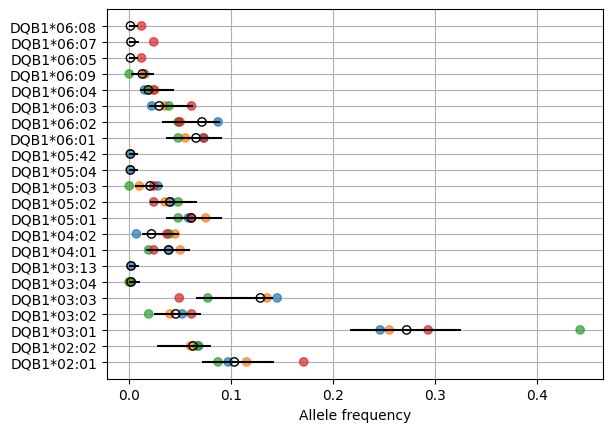

In [4]:
HLAfreq.plotAF(caf, aftab, hdi=hdi)

Above, we have calculated the 95% high density credible interval and added it to the combined allele frequency dataset. Note that by setting the `credible_interval` argument you can calculate any credible interval.

This has also added a column `post_mean` which is the mean of the posterior distribution for allele frequency estimated by the variance model. In general this is very similar to the `allele_freq` estimated by default. The difference is that it takes account of the variances mentioned before. However, in some cases the difference can become large and a warning is produced. Below we discuss when this can happen and what to do about it.

# Explaining differences between `allele_freq` and `post_mean`
`allele_freq` and `post_mean` are two different ways of estimating the average allele frequency for a set of studies. Because they are estimating the same thing they are very similar in most cases. However, in some situations they can diverge, in this section we discuss why that happens and what to do about it.

In no particular order the main causes are:
- Inappropriate prior
- Heterogeneity in estimated frequency for a single allele
- Issues with model convergence

## Inappropriate prior
Sometimes the `post_mean` and credible intervals are clearly too low. We have seen this when there are many alleles (usually >100) compared to the amount of data and many of these alleles are very rare. This is covered in more detail in the [working with priors example](https://github.com/Vaccitech/HLAfreq/blob/main/examples/working_with_priors.ipynb). Fortunately the fix is quite simple; instead of the default prior (a vector of $1$ s) use a vector of $1/k$ s where $k$ is the number of alleles. In simulations this resolved this issue even in extreme cases. Alternatively the default estimate of `allele_freq` is far more robust to this issue.

In [ ]:
# When k is the number of alleles
prior=[1/k]*k

## Heterogeneity in estimated frequency for a single allele
Below we calculate and plot the allele frequencies for DQB1 in Italy. DQB1*02:01 at the bottom of the plot shows that one study reports a much higher frequency than the others. This draws the `allele_freq` estimate (shown as a black open point) up and away from the other studies. This is analagous to an outlier skewing a mean. Whereas the credible intervals (the black horizontal line) and `post_mean` estimates remain centered on the majority of studies.

3 pages of results
Download complete
population   loci
Italy pop 4  DQB1    0.574
Name: allele_freq, dtype: float64
1 studies have total allele frequency < 0.95
2    206
3      1
Name: allele, dtype: int64
Multiple resolutions in AFtab. Fix with decrease_resolution()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.



There are several possible reasons, see the credible intervals example: https://github.com/Vaccitech/HLAfreq/blob/main/examples/credible_intervals.ipynb
If you have set `credible_interval` to < 0.95, this may be a non-issue.


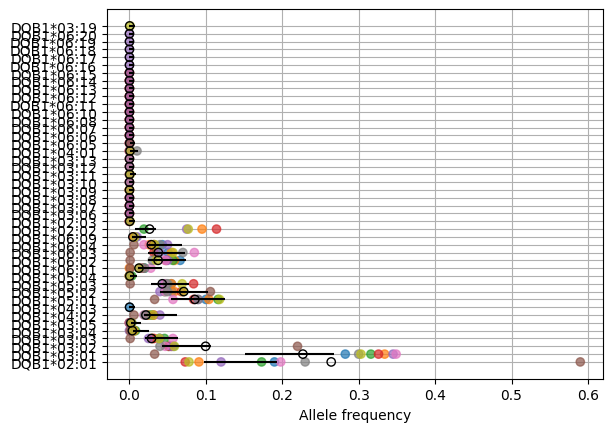

In [6]:
base_url = HLAfreq.makeURL("Italy", locus="DQB1")
aftab = HLAfreq.getAFdata(base_url)
aftab = HLAfreq.only_complete(aftab)
HLAfreq.check_resolution(aftab)
aftab = HLAfreq.decrease_resolution(aftab, 2)
caf = HLAfreq.combineAF(aftab)
hdi = HLAhdi.AFhdi(aftab,credible_interval=0.95)
HLAfreq.plotAF(caf, aftab, hdi=hdi)

In this case `allele_freq` and `post_mean` diverge because by modelling the sampling variance `post_mean` (and credible intervals) can better estimate the country allele frequency without being overly influenced by unusual studies.

What to do about this difference depends on your study. The `post_mean` estimate is probably the better estimate of average allele frequency for these datasets but it is important to check these datasets to make sure they are relevent to your study population. Below we look at each study estimate for DQB1*02:01.

In [7]:
aftab[aftab.allele=="DQB1*02:01"]

,allele,loci,population,allele_freq,sample_size
0,DQB1*02:01,DQB1,Germany DKMS - Italy minority,0.1898,1159
17,DQB1*02:01,DQB1,Italy Bergamo,0.0910,101
54,DQB1*02:01,DQB1,Italy Central,0.1730,380
69,DQB1*02:01,DQB1,Italy North pop 3,0.0730,97
102,DQB1*02:01,DQB1,Italy Rome,0.1200,100
144,DQB1*02:01,DQB1,Italy Sardinia pop2,0.5900,1129
159,DQB1*02:01,DQB1,Italy pop 2,0.1980,53
171,DQB1*02:01,DQB1,Italy pop 3,0.2300,179
185,DQB1*02:01,DQB1,Italy pop 5,0.0780,975


The high frequency estimate comes from the island population of Sardinia rather than mainland Italy. Depending on your study question you might choose to remove some studies and recalculate estimates. Note that you should remove the entire study, not just the alleles with different frequencies. Another study you might remove is Germany DKMS-Italy minority, as these are registered bone marrow donors in Germany who assigned their origin as Italy. Details about how data was collected are available on [allelefrequencies.net](http://www.allelefrequencies.net) if you look up the population.

## Issues with model convergence
If the model fails to converge the `post_mean` and credible interval estimates should not be used. Fortunately this appears to be rare and we have not observed it. However, if it does happen you could either use the default `allele_freq`, or dive into `pymc` to try and fit a better model.

The following sections describe diagnosing convergence issues and details of the model itself.

# Model details

This section describes the variance model in more detail as well as how to access the model and assess convergence.

The variance model used to estiamte high posterior density interval and `post_mean` is a Marginalized Dirichlet-Multinomial Model in PyMc as described [here](https://docs.pymc.io/en/v3/pymc-examples/examples/mixture_models/dirichlet_mixture_of_multinomials.html).

In brief, the global allele frequency is modelled as a Dirichlet distribution,
and each population (defined by `datasetID`) is a Dirichlet distribution draw from
the global Dirichlet distribution, and the observed allele count data of that
population is multinomial count data drawn from the population Dirichlet distribution.

The observed allele frequencies are transformed into allele counts using `weights`.
The variability of population allele frequencies around the global mean is defined
by a latent, lognormal variable `conc`.

## Fitting the model
If you suspect that the model is failing to converge you can fit the model and check it directly. The code to fit the model below is the same that `AFhdi()` uses internally. 

In [9]:
# Format data and fit variance model
c_array, allele_names = HLAhdi._make_c_array(aftab)
idata = HLAhdi._fit_Dirichlet_Multinomial(c_array)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


## Validating the model
Once you have fit the model you can validate it as you would any other PyMC model, in particular I recommend [posterior predictive checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) which can show that your estimates are being overly influenced by the prior as can happen with small datasets and large numbers of alleles. A basic overview is available [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#model-checking) and a more detailed check for biased parameters is described [here](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html#diagnosing-with-divergences).

Some basic checks are shown below. It's a good idea to check the `r_hat` values are close to 1. Higher `r_hat` values indicate that some chains have failed to converge and `pymc` will also give warnings for high values.

In [10]:
import arviz as az
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
frac[0],0.144,0.025,0.095,0.189,0.000,0.000,5064.0,2570.0,1.0
frac[1],0.020,0.008,0.007,0.034,0.000,0.000,4900.0,2553.0,1.0
frac[2],0.003,0.002,0.000,0.008,0.000,0.000,4228.0,2307.0,1.0
frac[3],0.209,0.030,0.152,0.264,0.000,0.000,4433.0,2760.0,1.0
frac[4],0.072,0.017,0.042,0.104,0.000,0.000,5285.0,2477.0,1.0
frac[5],0.042,0.011,0.021,0.063,0.000,0.000,4996.0,2143.0,1.0
frac[6],0.015,0.006,0.005,0.025,0.000,0.000,4635.0,2491.0,1.0
frac[7],0.008,0.004,0.002,0.015,0.000,0.000,4582.0,2966.0,1.0
frac[8],0.002,0.002,0.000,0.005,0.000,0.000,2501.0,1628.0,1.0
frac[9],0.002,0.002,0.000,0.004,0.000,0.000,2900.0,1691.0,1.0


An energy plot can check that the sampler performed well, if it did the two distributions should be similar.


<AxesSubplot: >

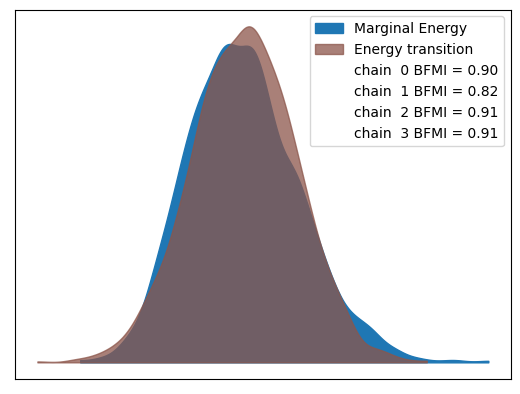

In [11]:
az.plot_energy(idata)


Trace plots can also be used to check convergence and mixing. In the left hand plots we want the different chains to have converged to the same distributions. And in the right hand plot we want to see no trends or evidence of chains getting stuck.

With large numbers of alleles you may have to increase the max_subplots to see all alleles and avoid warnings.

/home/dwells/miniconda3/envs/hlafreq/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (45), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'frac\n0'}>,
        <AxesSubplot: title={'center': 'frac\n0'}>],
       [<AxesSubplot: title={'center': 'frac\n1'}>,
        <AxesSubplot: title={'center': 'frac\n1'}>],
       [<AxesSubplot: title={'center': 'frac\n2'}>,
        <AxesSubplot: title={'center': 'frac\n2'}>],
       [<AxesSubplot: title={'center': 'frac\n3'}>,
        <AxesSubplot: title={'center': 'frac\n3'}>],
       [<AxesSubplot: title={'center': 'frac\n4'}>,
        <AxesSubplot: title={'center': 'frac\n4'}>],
       [<AxesSubplot: title={'center': 'frac\n5'}>,
        <AxesSubplot: title={'center': 'frac\n5'}>],
       [<AxesSubplot: title={'center': 'frac\n6'}>,
        <AxesSubplot: title={'center': 'frac\n6'}>],
       [<AxesSubplot: title={'center': 'frac\n7'}>,
        <AxesSubplot: title={'center': 'frac\n7'}>],
       [<AxesSubplot: title={'center': 'frac\n8'}>,
        <AxesSubplot: title={'center': 'frac\n8'}>],
       [<AxesSubplot: title={'center': 'frac\n9'}>,
   

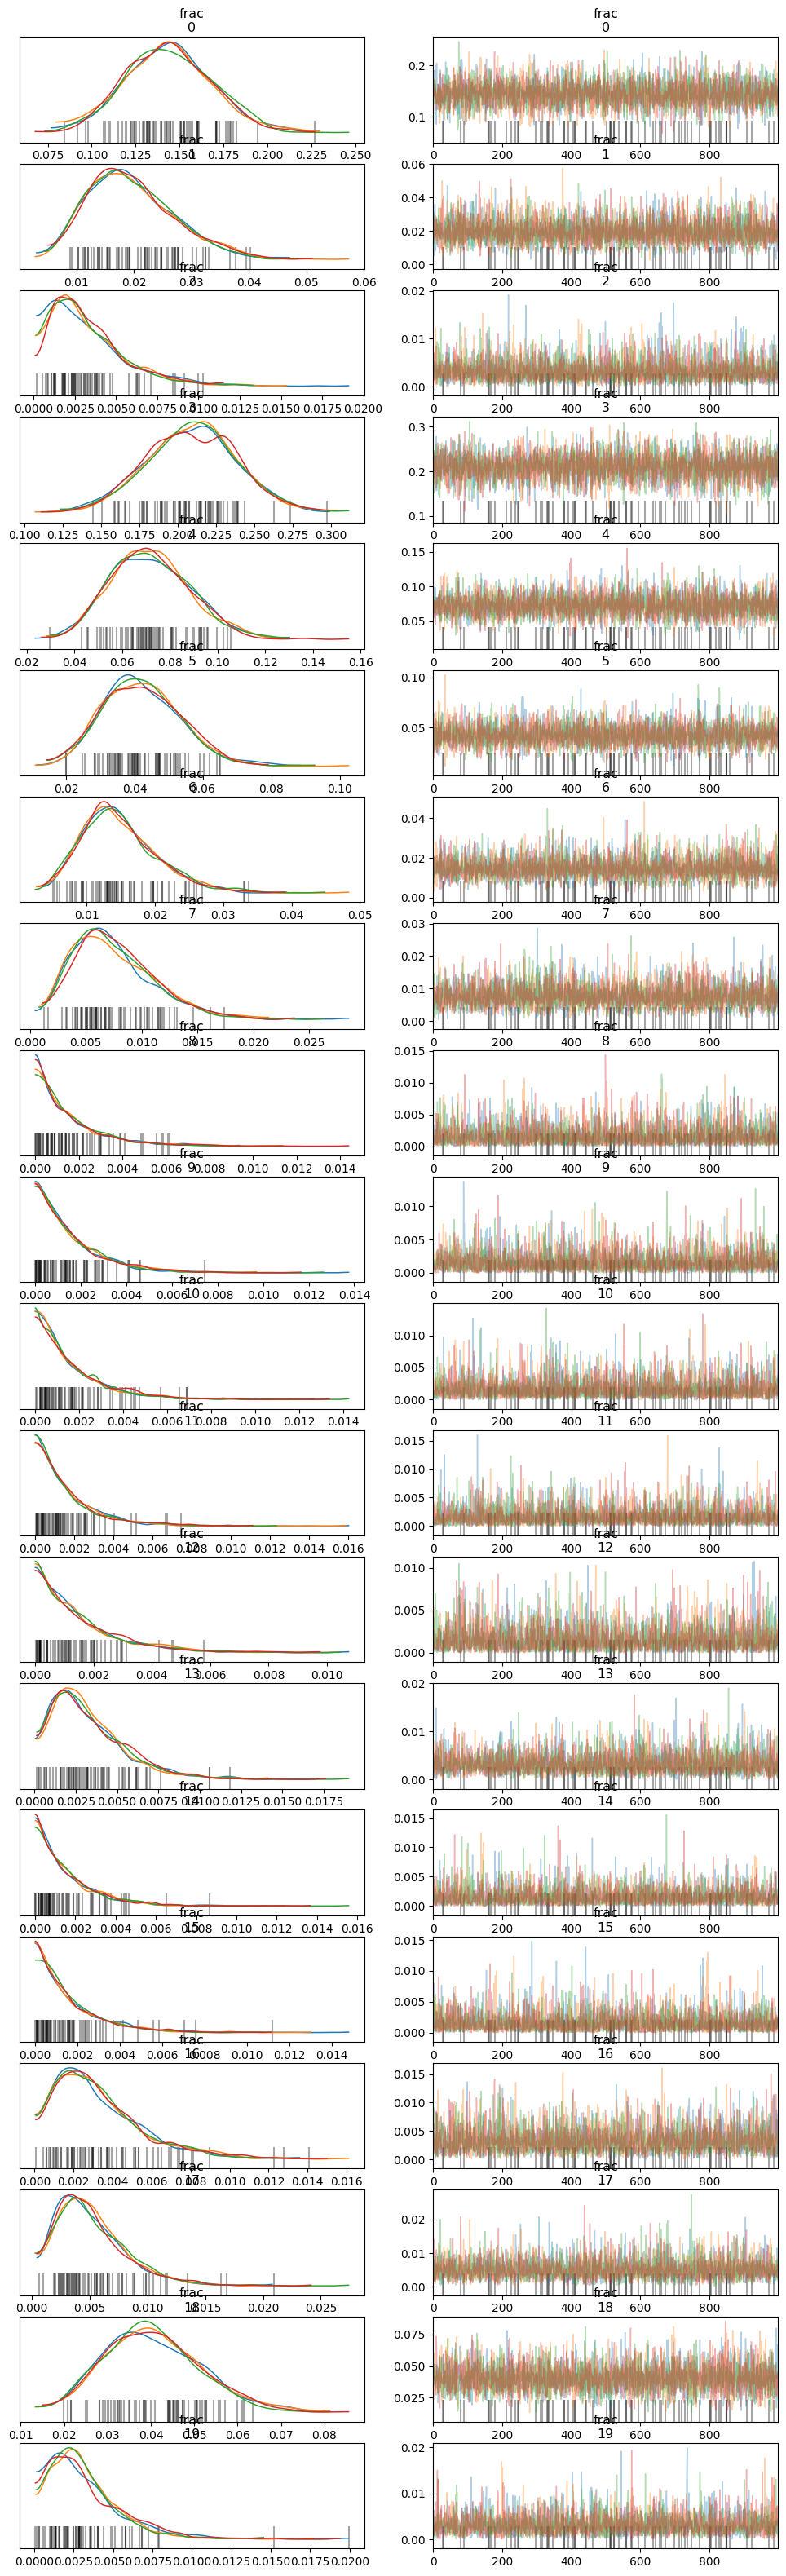

In [12]:

az.plot_trace(idata, compact=False, combined=False)